In [59]:
# Math 
from math import sqrt
from scipy import stats
import statistics
import os

# General
import numpy as np
import pandas as pd

# Sklearn Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Graph
from tabulate import tabulate

# Custom Module's
from wrangle import wrangle_zillow, remove_outliers
from prepare import add_scaled_columns

from pydataset import data

import warnings
warnings.filterwarnings("ignore")

## Load the tips dataset.

In [60]:
df = data("tips")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 1 to 244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


In [62]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


### Create a column named tip_percentage. This should be the tip amount divided by the total bill.

In [63]:
df["tip_percentage"] = df.tip/df.total_bill

In [64]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage
1,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
2,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
3,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
4,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
5,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


### Create a column named price_per_person. This should be the total bill divided by the party size.

In [65]:
df["price_per_person"] = df.total_bill/df.size

In [66]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,0.008704
2,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,0.005297
3,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,0.010763
4,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,0.012131
5,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,0.012597


### Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount? The tip percentage?

    price_per_person

### Use select k best and recursive feature elimination to select the top 2 features for predicting tip amount. What are they?

In [67]:
df.isnull().sum()

total_bill          0
tip                 0
sex                 0
smoker              0
day                 0
time                0
size                0
tip_percentage      0
price_per_person    0
dtype: int64

In [68]:
cols = ['total_bill', 'tip', 'tip_percentage', 'price_per_person']

In [69]:
len(df)

244

In [70]:
df = remove_outliers(df, 1.5, cols)

In [71]:
len(df)

218

In [72]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [73]:
train.shape, validate.shape, test.shape

((121, 9), (53, 9), (44, 9))

<AxesSubplot:>

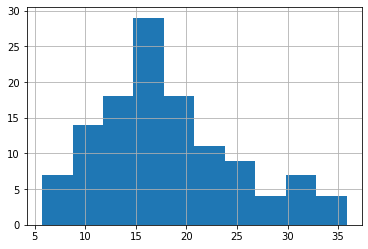

In [80]:
train.total_bill.hist()

In [75]:
train, validate, test = add_scaled_columns(train, validate, test, sklearn.preprocessing.MinMaxScaler(), cols)

<AxesSubplot:>

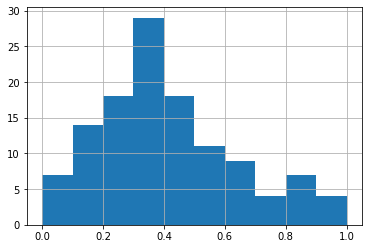

In [81]:
train.total_bill_scaled.hist()

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 55 to 15
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_bill               121 non-null    float64
 1   tip                      121 non-null    float64
 2   sex                      121 non-null    object 
 3   smoker                   121 non-null    object 
 4   day                      121 non-null    object 
 5   time                     121 non-null    object 
 6   size                     121 non-null    int64  
 7   tip_percentage           121 non-null    float64
 8   price_per_person         121 non-null    float64
 9   total_bill_scaled        121 non-null    float64
 10  tip_scaled               121 non-null    float64
 11  tip_percentage_scaled    121 non-null    float64
 12  price_per_person_scaled  121 non-null    float64
dtypes: float64(8), int64(1), object(4)
memory usage: 13.2+ KB


In [83]:
X_train_scaled = train[['tip_percentage_scaled', 'price_per_person_scaled', 'total_bill_scaled']]
y_train = train['tip_scaled']

### Use select k best and recursive feature elimination to select the top 2 features for predicting tip percentage. What are they?

In [87]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=1)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['total_bill_scaled']

In [89]:
# RFE time

# Make the thing(s)
lm = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=2)

# Fit the thing
rfe.fit(X_train_scaled, y_train)

# use the thing
rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
rfe_columns

['tip_percentage_scaled', 'total_bill_scaled']

In [90]:
# RFE time

# Make the thing(s)
lm = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=1)

# Fit the thing
rfe.fit(X_train_scaled, y_train)

# use the thing
rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
rfe_columns

['total_bill_scaled']

### Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features your are selecting?

    Yes it did change when i changed n_features_to_select to 1 from 2

### Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [91]:
def select_kbest(X, y, k):
    # make the object
    kbest = sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.f_regression,
        k=k)

    # fit the object
    kbest.fit(X, y)
    
    # use the object (.get_support() is that array of booleans to filter the list of column names)
    return X.columns[kbest.get_support()].tolist()

In [92]:
kbest_feats = select_kbest(X_train_scaled, y_train, 2)
kbest_feats

['price_per_person_scaled', 'total_bill_scaled']

### Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [93]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by="Rank", ascending=True)
    return ranks

In [94]:
def select_rfe(X, y, k):
    # make the thing
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=k)

    # Fit the thing
    rfe.fit(X, y)
    
    # use the thing
    features_to_use = X.columns[rfe.support_].tolist()
    
    # we need to send show_feature_rankings a trained/fit RFE object
    all_rankings = show_features_rankings(X, rfe)
    
    return features_to_use, all_rankings

In [96]:
select_rfe(X_train_scaled, y_train, 1)

(['total_bill_scaled'],
                        Var  Rank
 2        total_bill_scaled     1
 0    tip_percentage_scaled     2
 1  price_per_person_scaled     3)

### Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [97]:
swiss = data('swiss')
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [99]:
def split(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [100]:
# Split the data
train, validate, test = split(swiss, stratify_by="Fertility")

# Setup X and y
X_train = train.drop(columns='Fertility')
y_train = train.Fertility

X_validate = validate.drop(columns='Fertility')
y_validate = validate.Fertility

X_test = test.drop(columns='Fertility')
y_test = test.Fertility

In [101]:
# Scale the data
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Use the scaler to transform train, validate, test
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)


# Turn everything into a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [102]:
select_kbest(X_train_scaled, y_train, 3)

['Examination', 'Catholic', 'Infant.Mortality']

In [103]:
# Find the top 3 features using RFE
selected_features, all_rankings = select_rfe(X_train, y_train, 3)
print(selected_features)
all_rankings

['Agriculture', 'Examination', 'Infant.Mortality']


,Var,Rank
0,Agriculture,1
1,Examination,1
4,Infant.Mortality,1
2,Education,2
3,Catholic,3
